## Importing Neccessary modules

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer as sia
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

## Original import file

In [3]:
path="Final_Toys_and_Games_used.csv" ## <-- Mention path here alone
original=pd.read_csv(path)
original.dropna(inplace=True)

## NLP data

In [4]:
t=time()
games=original.copy()
games.drop(['reviewTime',"asin",'reviewerID','reviewerName','verified','image_uploaded','reviewText','summary'],axis=1,inplace=True)
games.head(3)

,overall,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,compound
0,2,when it comes to a dm s screen the space on th...,95,negative,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,-0.0711
1,1,an open letter to galeforce9 your unpainted mi...,143,negative,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,-0.4404
2,3,nice art nice printing why two panels are fill...,261,positive,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,0.4019


In [5]:
final=games.copy()

## Sentiment analysis

In [6]:
stop_words= set(stopwords.words('english'))
final['review'] = final['review'].progress_apply(lambda x: ' '.join([item for item in x.split() if (item not in stop_words) and (item.isalnum())]))

100%|██████████| 189211/189211 [00:03<00:00, 56812.85it/s]


In [7]:
vader=sia()

In [8]:
final['compound'] = final['review'].progress_apply(lambda x: vader.polarity_scores(x)['compound'])

100%|██████████| 189211/189211 [01:38<00:00, 1912.41it/s]


In [9]:
final.loc[final['compound'] > 0.1, 'Sentiment'] = 'positive'
final.loc[(final['compound'] <= 0.1) & (final['compound'] > -0.1), 'Sentiment'] = 'neutral'
final.loc[final['compound'] <= -0.1, 'Sentiment'] = 'negative'

In [10]:
final.head()

,overall,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,compound
0,2,comes dm screen space screen absolute premium ...,95,negative,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,-0.9552
1,1,open letter galeforce9 unpainted miniatures ba...,143,negative,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,-0.2732
2,3,nice art nice printing two panels filled gener...,261,positive,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,0.8662
3,5,amazing buy bought gift new dm perfect five stars,17,positive,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,0.8860
4,1,review gf9 previous screens completely unneces...,28,negative,toys games grown up toys games,this screen is the perfect companion for those...,Dungeons &amp; Dragons - &quot;Storm Kings Thu...,gale force nine,178217.0,Toys & Games,-0.8000


Text(0.5, 1.0, 'Sentiment')

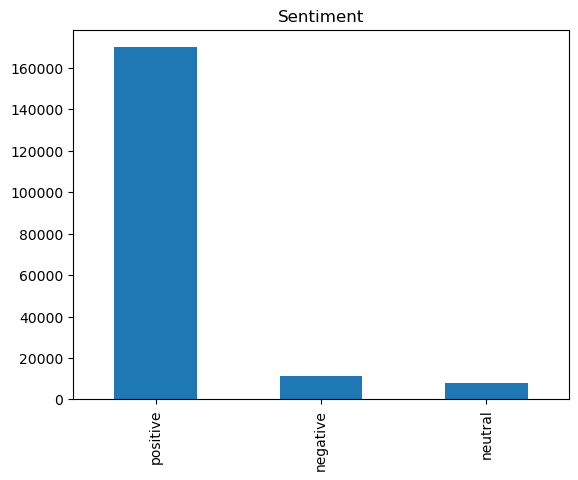

In [11]:
final.Sentiment.value_counts().plot(kind='bar')
plt.title('Sentiment')

In [12]:
nlp_clean=final.copy()

## Stacked models of NB and LogisticRegression

In [13]:
nb_model=MultinomialNB()
logreg_model=LogisticRegression(max_iter=1000)

stacked_model=StackingClassifier(estimators=[('nb', nb_model), ('logreg', logreg_model)],
    final_estimator=LogisticRegression(max_iter=1000))


In [14]:
stacked_model

StackingClassifier(estimators=[('nb', MultinomialNB()),
                               ('logreg', LogisticRegression(max_iter=1000))],
                   final_estimator=LogisticRegression(max_iter=1000))

## Train test split

In [15]:
xtrain,xtest,ytrain,ytest=train_test_split(final.review,final.Sentiment,test_size=0.2,random_state=22)

## Vectorizing

In [16]:
vectorizer=TfidfVectorizer()
xtraintf=vectorizer.fit_transform(xtrain)
xtesttf=vectorizer.transform(xtest)

## Model training

In [17]:
stacked_model.fit(xtraintf, ytrain)
y_pred=stacked_model.predict(xtesttf)

## Classification Model prediction and evaluation

In [18]:
accuracy = accuracy_score(ytest, y_pred)
precision = precision_score(ytest, y_pred,average='weighted',zero_division=1)
recall = recall_score(ytest, y_pred,average='weighted')
f1 = f1_score(ytest, y_pred,average='weighted')


print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Accuracy: 0.9626086726739423
Precision: 0.9605532155501285
Recall: 0.9626086726739423
F1 score: 0.9610663927155956


## Wordcloud building

In [19]:
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer

reviews = final['review']


analyzer = SentimentIntensityAnalyzer()


# Generate a list of (word, sentiment score) tuples for each review
positive=[]
negative=[]


for review in tqdm(reviews):
    compound_score = analyzer.polarity_scores(review)['compound']
    if compound_score > 0.8:
        positive.append(review)
    elif compound_score < -0.3:
        negative.append(review)

100%|██████████| 189211/189211 [01:45<00:00, 1797.20it/s]


In [20]:
def sizer(sentence):
    sentence=" ".join(item for item in sentence.split(" ") if(len(item)>=4))
    return sentence

positive=[sizer(item) for item in positive]
negative=[sizer(item) for item in negative]

In [21]:
from collections import Counter
from autocorrect import Speller
from tqdm import tqdm

def corpus_create(reviews, emotion):
    senti = sia()
    spell = Speller(lang='en')
    notebook = Counter(spell(word.lower()) for review in tqdm(reviews, desc='Processing reviews') for word in review.split() if senti.polarity_scores(word)[emotion] == 1)
    return notebook



positive_words=corpus_create(positive,'pos')
negative_words=corpus_create(negative,'neg')

Processing reviews: 100%|██████████| 8482/8482 [00:46<00:00, 180.72it/s]


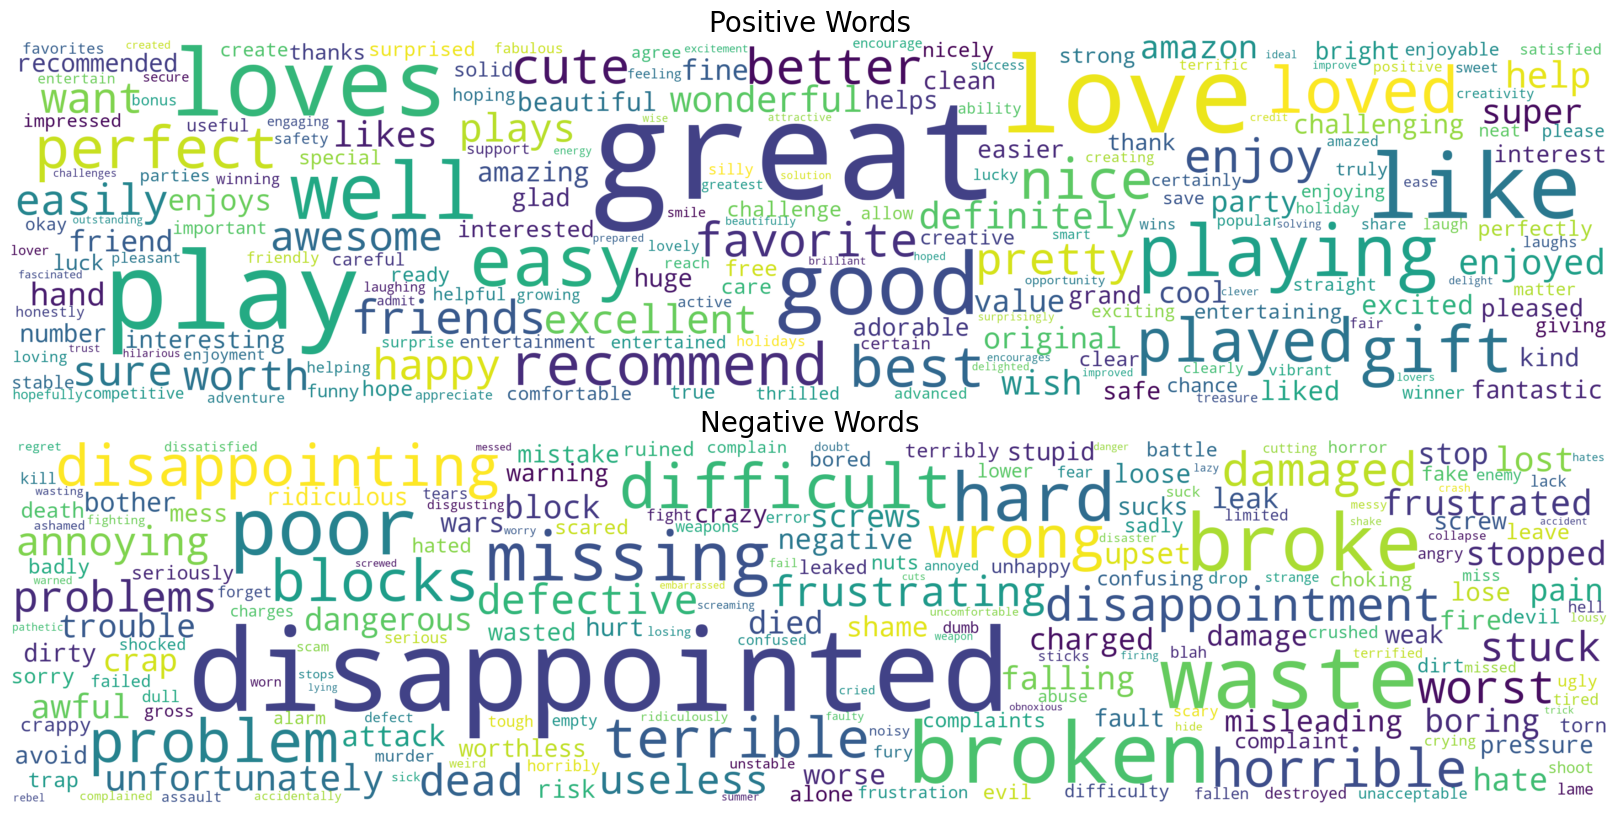

In [22]:
wordcloud = WordCloud(width=3500, height=800, max_font_size=300, background_color='white',
                      colormap='viridis', prefer_horizontal=1.0,
                      contour_width=3, contour_color='white',
                      ).generate_from_frequencies(frequencies=positive_words)

wordcloud_neg = WordCloud(width=3500, height=800, max_font_size=250, background_color='white',
                          colormap='viridis', prefer_horizontal=1.0,
                          contour_width=3, contour_color='white',
                          ).generate_from_frequencies(frequencies=negative_words)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

plt.subplots_adjust(hspace=10)

ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title('Positive Words', fontsize=20)
ax1.axis('off')

ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Negative Words', fontsize=20)
ax2.axis('off')

plt.tight_layout(pad=0)
plt.show()


In [23]:
#Time taken to run ML part  411.8663830757141
print('Time taken to run ML part with patch',time()-t)

Time taken to run ML part with patch 1084.6638293266296


# ML

In [24]:
final = original.sort_values(by='reviewTime').dropna()
final.dropna(inplace=True)

In [25]:
final.sort_values(by='reviewTime', inplace=True)

In [26]:
df = final          # optional, depending on what you want to do next
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,image_uploaded,compound
13133,5,False,1999-10-06,A1DTOHMM2Y5KY0,1572810939,Michael J Woznicki,ready for hearts to meet spades and whist well...,the game was a great time for everyone,ready for hearts to meet spades and whist well...,194,positive,toys games games card games,win the exact number of tricks you bid,US Games Wizard Card Game Deluxe,us games,6985.0,Toys & Games,no,0.6249
14306,5,True,1999-12-11,AKALUPQJFJVZ0,157982319X,D.T.,this drill is great i returned a volt makita a...,great drill,this drill is great i returned a volt makita a...,43,positive,toys games stuffed animals plush toys plush fi...,when a baby bat takes his first solo flight th...,"MerryMakers Nightsong Plush Doll, 11-Inch",merrymakers,1028501.0,Toys & Games,no,0.6249


In [27]:
# Splitting the data into train and test sets

x_train,x_test,y_train,y_test=train_test_split(df['summary'],df['Sentiment'],test_size=0.30,random_state=42)

a=x_test
b=y_test

In [28]:
tf=TfidfVectorizer(sublinear_tf=True, 
                            max_df=0.5, 
                            min_df=1,
                            stop_words=stopwords.words('english'),
                            use_idf=True )
x_train=tf.fit_transform(x_train)          # transforming the train data
x_test=tf.transform(x_test)

In [29]:
lr=LogisticRegression(max_iter=50)   # logistic regression model lib
ovr=OneVsRestClassifier(lr)          # one vs rest classifier due to multilabel class
ovr.fit(x_train,y_train)
y_pred = ovr.predict(x_test)         # predicting the model

In [30]:
f1= f1_score(y_test,y_pred,average='weighted') # class is inbalance thats why we are using f1 score to get performance

In [31]:
# Predicting the model and calculating the accuracy, recall, precision, and confusion matrix
print("Accuracy Score: ", accuracy_score(y_test,y_pred)*100)
print('F1 score for logistic regression model:', round(f1*100,2), '%')
print("Recall Score : ", recall_score(y_test,y_pred,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,y_pred,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,y_pred)*100)

Accuracy Score:  95.28750616587979
F1 score for logistic regression model: 94.97 %
Recall Score :  95.28750616587979
Precision Score :  95.1666590011774
Confusion Matrix :
  [[ 245100   72200   97800]
 [   4200 1977000   10600]
 [  24600   58100 3186800]]


In [32]:
a1 = accuracy_score(y_test,y_pred)
r1 = recall_score(y_test,y_pred,average='weighted')
p1 = precision_score(y_test,y_pred,average='weighted')

In [33]:
print('Accuracy score for logistic regression model:', round(a1*100,2), '%')
print('F1 score for logistic regression model:', round(f1*100,2), '%')
print('Recall Score for logistic regression model:', round(r1*100,2), '%')
print('Precision Score for logistic regression model:', round(p1*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,y_pred)*100)

Accuracy score for logistic regression model: 95.29 %
F1 score for logistic regression model: 94.97 %
Recall Score for logistic regression model: 95.29 %
Precision Score for logistic regression model: 95.17 %
Confusion Matrix :
  [[ 245100   72200   97800]
 [   4200 1977000   10600]
 [  24600   58100 3186800]]


- Naive Bayes Classifier

In [34]:
Naive = MultinomialNB()                  # multinomial model lib
model =Naive.fit(x_train,y_train)        # fitting of model
predictions_NB = Naive.predict(x_test)   # prediction of model

In [35]:
f_nb= f1_score(predictions_NB, y_test,average='weighted') # class is inbalance thats why we are using f1 score to get performance

In [36]:
# Predicting the model and calculating the accuracy, recall, precision, and confusion matrix
print("Accuracy Score: ", accuracy_score(y_test,predictions_NB)*100)
print('F1 score for logistic regression model:', round(f_nb*100,2), '%')
print("Recall Score : ", recall_score(y_test,predictions_NB,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,predictions_NB,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,predictions_NB)*100)

Accuracy Score:  85.3498696356846
F1 score for logistic regression model: 86.27 %
Recall Score :  85.3498696356846
Precision Score :  87.36884969137564
Confusion Matrix :
  [[ 173300   20800  221000]
 [   4100 1427300  560400]
 [  12900   12400 3244200]]


In [37]:
a_nb = accuracy_score(y_test,predictions_NB)
r_nb = recall_score(y_test,predictions_NB,average='weighted')
p_nb = precision_score(y_test,predictions_NB,average='weighted')

In [38]:
print('Accuracy score for Naive Bayes Classifier model:', round(a_nb*100,2), '%')
print('F1 score for Naive Bayes Classifier model:', round(f_nb*100,2), '%')
print('Recall Score for Naive Bayes Classifier model:', round(r_nb*100,2), '%')
print('Precision Score for Naive Bayes Classifier model:', round(p_nb*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,predictions_NB)*100)

Accuracy score for Naive Bayes Classifier model: 85.35 %
F1 score for Naive Bayes Classifier model: 86.27 %
Recall Score for Naive Bayes Classifier model: 85.35 %
Precision Score for Naive Bayes Classifier model: 87.37 %
Confusion Matrix :
  [[ 173300   20800  221000]
 [   4100 1427300  560400]
 [  12900   12400 3244200]]


- Random Forest Classifier

In [39]:
# importing library
from sklearn.ensemble import RandomForestClassifier

In [40]:
model4 = RandomForestClassifier(max_depth=5).fit(x_train, y_train)     # making and training the model
y2_pred = model4.predict(x_test)

In [41]:
f_rf= f1_score(y2_pred, y_test,average='weighted')

In [42]:
print("Accuracy Score: ", accuracy_score(y_test,y2_pred)*100)
print('F1 score for random forest classifier model:', round(f_rf*100,2), '%')
print("Recall Score : ", recall_score(y_test,y2_pred,average='weighted')*100)
print("Precision Score : ", precision_score(y_test,y2_pred,average='weighted')*100)
print("Confusion Matrix :\n ", confusion_matrix(y_test,y2_pred)*100)

Accuracy Score:  57.598125572545975
F1 score for random forest classifier model: 73.09 %
Recall Score :  57.598125572545975
Precision Score :  33.175440694707746
Confusion Matrix :
  [[      0       0  415100]
 [      0       0 1991800]
 [      0       0 3269500]]


In [43]:
a_rf = accuracy_score(y_test,y2_pred)
r_rf = recall_score(y_test,y2_pred,average='weighted')
p_rf = precision_score(y_test,y2_pred,average='weighted')

In [44]:
print('Accuracy score for Random Forest Classifier model:', round(a_rf*100,2), '%')
print('F1 score for Random Forest Classifier model:', round(f_rf*100,2), '%')
print('Recall Score for Random Forest Classifier model:', round(r_rf*100,2), '%')
print('Precision Score for Random Forest Classifier model:', round(p_rf*100,2), '%')
print("Confusion Matrix :\n ", confusion_matrix(y_test,y2_pred)*100)

Accuracy score for Random Forest Classifier model: 57.6 %
F1 score for Random Forest Classifier model: 73.09 %
Recall Score for Random Forest Classifier model: 57.6 %
Precision Score for Random Forest Classifier model: 33.18 %
Confusion Matrix :
  [[      0       0  415100]
 [      0       0 1991800]
 [      0       0 3269500]]


In [45]:
dff=pd.DataFrame()            # creating dataframe for actual and predicted value
dff['reviewText']=a
dff['Actual']=b
dff['pred']=y_pred
dff

,reviewText,Actual,pred
55206,five stars,neutral,neutral
158122,great game,positive,positive
124920,five stars,neutral,neutral
29133,the game look complex but it is very simple an...,positive,positive
176709,four stars,neutral,neutral
...,...,...,...
160147,great balls,positive,positive
95209,how to entertain a child,positive,positive
73123,don t waste your time,negative,negative
123528,a must have,neutral,neutral


- Clustering
- K-Means

In [46]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() # encoder function
df['Sentiment_type']= label_encoder.fit_transform(df['Sentiment'])

In [47]:
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,image_uploaded,compound,Sentiment_type
13133,5,False,1999-10-06,A1DTOHMM2Y5KY0,1572810939,Michael J Woznicki,ready for hearts to meet spades and whist well...,the game was a great time for everyone,ready for hearts to meet spades and whist well...,194,positive,toys games games card games,win the exact number of tricks you bid,US Games Wizard Card Game Deluxe,us games,6985.0,Toys & Games,no,0.6249,2
14306,5,True,1999-12-11,AKALUPQJFJVZ0,157982319X,D.T.,this drill is great i returned a volt makita a...,great drill,this drill is great i returned a volt makita a...,43,positive,toys games stuffed animals plush toys plush fi...,when a baby bat takes his first solo flight th...,"MerryMakers Nightsong Plush Doll, 11-Inch",merrymakers,1028501.0,Toys & Games,no,0.6249,2


In [48]:
df.shape

(189211, 20)

In [49]:
df['rev_word_count']= df['summary'].apply(lambda x: len(x.strip().split()))      # Count of word
df['unique_word_count']= df['summary'].apply(lambda x: len(set(str(x).split()))) # Unique count of word

<AxesSubplot:xlabel='compound', ylabel='rank'>

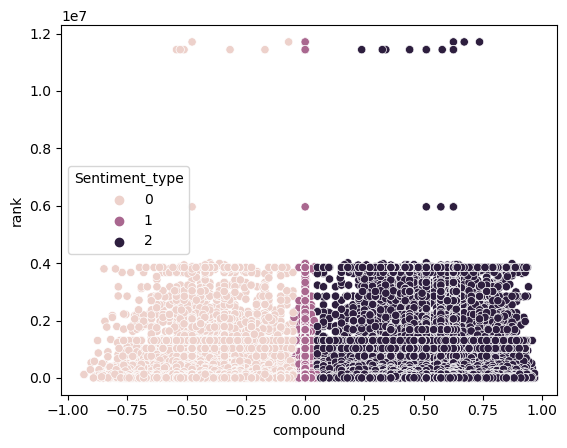

In [50]:
sns.scatterplot(x=df['compound'],y=df['rank'],hue=df['Sentiment_type'],data=df)

In [51]:
df_clu=df[['compound','rank']]   # Taking only compound and price column
df_clu

,compound,rank
13133,0.6249,6985.0
14306,0.6249,1028501.0
38500,0.8020,41908.0
14305,0.2732,1028501.0
55385,0.0000,1346735.0
...,...,...
139668,0.0000,6566.0
101348,0.0000,1389.0
113387,0.0000,95.0
113388,0.0000,95.0


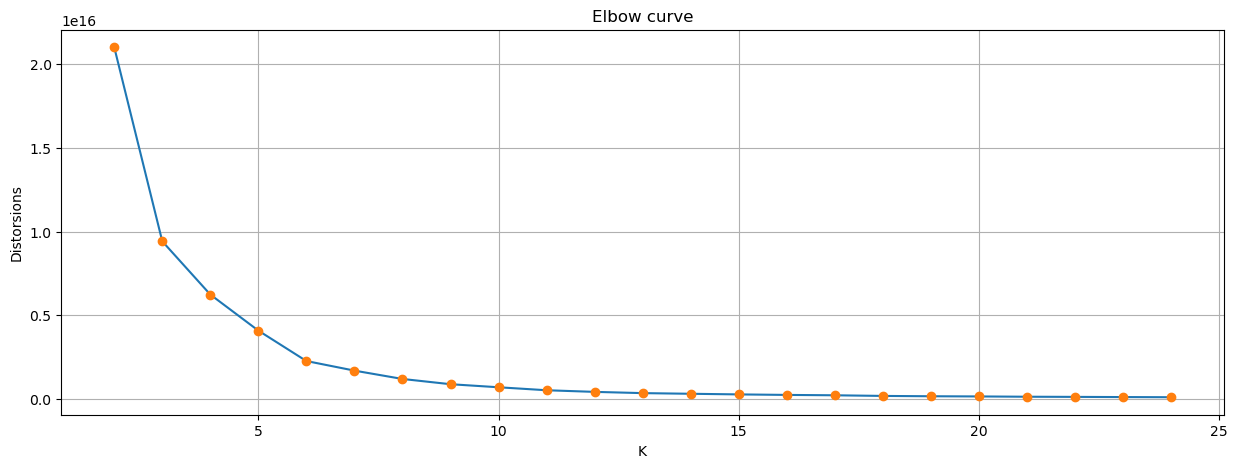

In [52]:
kk=[]                                    # empty list created
distorsions = []                         # empty list created
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k)        # kmean lib is used 
    kmeans.fit(df_clu)
    distorsions.append(kmeans.inertia_)
    kk.append(k)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 25), distorsions)
plt.plot(kk,distorsions,'o')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Distorsions')
plt.title('Elbow curve');

In [53]:
cluster_model = KMeans(n_clusters=5)   # best silhoutte score 
pre_cluster=cluster_model.fit_predict(df_clu)
pre_cluster

array([0, 2, 0, ..., 0, 0, 0])

In [54]:
df['cluster_pre']=pre_cluster

In [55]:
df['cluster_pre'].unique()

array([0, 2, 4, 1, 3])

In [56]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,...,title,brand,rank,main_cat,image_uploaded,compound,Sentiment_type,rev_word_count,unique_word_count,cluster_pre
13133,5,False,1999-10-06,A1DTOHMM2Y5KY0,1572810939,Michael J Woznicki,ready for hearts to meet spades and whist well...,the game was a great time for everyone,ready for hearts to meet spades and whist well...,194,...,US Games Wizard Card Game Deluxe,us games,6985.0,Toys & Games,no,0.6249,2,8,8,0
14306,5,True,1999-12-11,AKALUPQJFJVZ0,157982319X,D.T.,this drill is great i returned a volt makita a...,great drill,this drill is great i returned a volt makita a...,43,...,"MerryMakers Nightsong Plush Doll, 11-Inch",merrymakers,1028501.0,Toys & Games,no,0.6249,2,2,2,2
38500,5,False,1999-12-11,AXH34TXSUTQK1,B00000GBQL,Russell Belfer,i enjoy wise and otherwise much more than the ...,funny and easy to play,i enjoy wise and otherwise much more than the ...,74,...,Wise and Otherwise,wise and otherwise,41908.0,Toys & Games,no,0.8020,2,5,5,0
14305,5,False,1999-12-19,A3370XCM3EVNLH,157982319X,M. Yavercovski,i chose this drill and over the more powerfull...,light weight and well balanced,i chose this drill and over the more powerfull...,91,...,"MerryMakers Nightsong Plush Doll, 11-Inch",merrymakers,1028501.0,Toys & Games,no,0.2732,2,5,5,2
55385,5,False,1999-12-27,A36MQW22BD8LJU,B00000IVQB,Chess Heart,the barbie bug has finally bitten my year old ...,up up and away just watch out for the small bits,the barbie bug has finally bitten my year old ...,558,...,Mattel Barbie Airplane,mattel,1346735.0,Toys & Games,yes,0.0000,1,11,10,2


In [57]:
X = df.loc[:, ['rank', 'compound']].values  # here we are taking compound and price column
xx=pd.DataFrame(X)

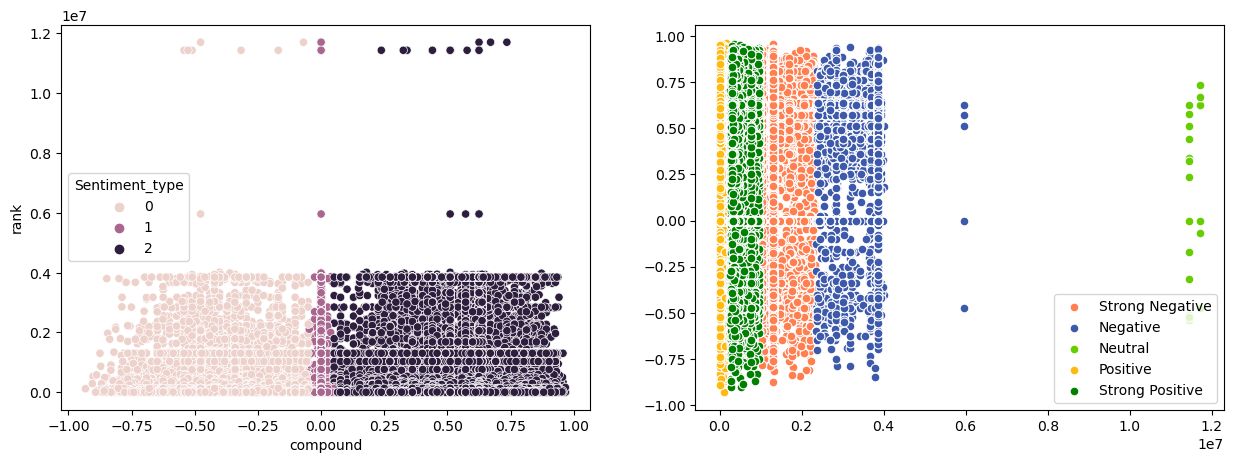

In [58]:
# both graph should be explained when new data is imported
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(x=df['compound'],y=df['rank'],hue=df['Sentiment_type'],c=cluster_model.predict(df_clu))
plt.subplot(122)
plt.scatter(X[pre_cluster == 2, 0], X[pre_cluster == 2, 1], s = 40 ,c = '#FF7F50',edgecolors='white',linewidth=0.8, label = 'Strong Negative')
plt.scatter(X[pre_cluster == 1, 0], X[pre_cluster == 1, 1], s = 40 ,c = '#3D59AB',edgecolors='white',linewidth=0.8, label = 'Negative')
plt.scatter(X[pre_cluster == 3, 0], X[pre_cluster == 3, 1], s = 40 ,c = '#66CD00',edgecolors='white',linewidth=0.8, label = 'Neutral')
plt.scatter(X[pre_cluster == 0, 0], X[pre_cluster == 0, 1], s = 40 ,c = '#FFB90F',edgecolors='white',linewidth=0.8, label = 'Positive')
plt.scatter(X[pre_cluster == 4, 0], X[pre_cluster == 4, 1], s = 40 ,c = 'green',edgecolors='white',linewidth=0.8, label = 'Strong Positive')
plt.legend()
plt.show()

In [81]:
import pandas as pd
import numpy as np


df['sentiment_type'] = pd.cut(df['compound'], bins=5, labels=False)


df['sentiment'] = np.round((df['sentiment_type'] / 5) * 5)


print(df.sentiment.head())

13133    4.0
14306    4.0
38500    4.0
14305    3.0
55385    2.0
Name: sentiment, dtype: float64


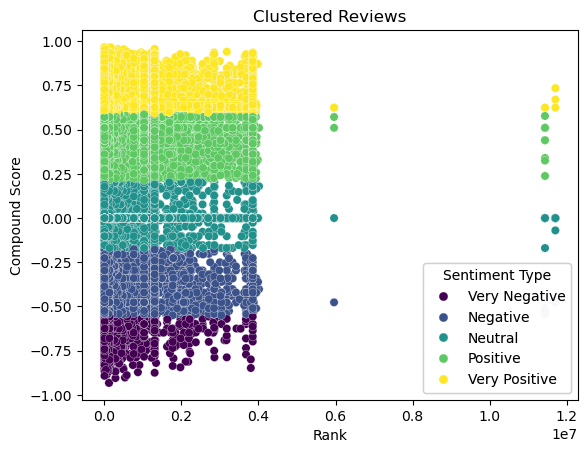

In [82]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
scatter = ax.scatter(df['rank'], df['compound'], c=df['sentiment'], cmap='viridis', edgecolors='white', linewidth=0.2)

plt.xlabel('Rank')
plt.ylabel('Compound Score')
plt.title('Clustered Reviews')


sentiment_labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
legend_elements = scatter.legend_elements()[0], sentiment_labels


legend1 = ax.legend(*legend_elements, loc="lower right", title="Sentiment Type")
ax.add_artist(legend1)

# Show the plot
plt.show()

## TSA data

In [59]:
final=pd.read_csv(path, parse_dates=True,index_col ='reviewTime')
final=final.sort_values(by='reviewTime')
final.head(3)

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,review,Number_of_Words_in_review,Sentiment,category,description,title,brand,rank,main_cat,image_uploaded,compound
reviewTime,,,,,,,,,,,,,,,,,,
1999-10-06,5,False,A1DTOHMM2Y5KY0,1572810939,Michael J Woznicki,ready for hearts to meet spades and whist well...,the game was a great time for everyone,ready for hearts to meet spades and whist well...,194,positive,toys games games card games,win the exact number of tricks you bid,US Games Wizard Card Game Deluxe,us games,6985.0,Toys & Games,no,0.6249
1999-12-11,5,False,AXH34TXSUTQK1,B00000GBQL,Russell Belfer,i enjoy wise and otherwise much more than the ...,funny and easy to play,i enjoy wise and otherwise much more than the ...,74,positive,toys games games board games,party game in wise and otherwise there are 2 ...,Wise and Otherwise,wise and otherwise,41908.0,Toys & Games,no,0.8020
1999-12-11,5,True,AKALUPQJFJVZ0,157982319X,D.T.,this drill is great i returned a volt makita a...,great drill,this drill is great i returned a volt makita a...,43,positive,toys games stuffed animals plush toys plush fi...,when a baby bat takes his first solo flight th...,"MerryMakers Nightsong Plush Doll, 11-Inch",merrymakers,1028501.0,Toys & Games,no,0.6249


In [60]:
df1=final[final['Sentiment']=='positive'] # featching data only for positive sentiment
df2=final[final['Sentiment']=='negative'] # featching data only for negative sentiment
df3=final[final['Sentiment']=='neutral']  # featching data only for neutral sentiment
print("Positive:{} , Negative:{} , Neutral:{}".format(df1.shape,df2.shape,df3.shape)) # checking shape of all data 

Positive:(108921, 18) , Negative:(13671, 18) , Neutral:(66669, 18)


In [61]:
#function for resampleing the data into months then ploting its actual,trend, seasonality,residual plots with acf & pacf plot

def resample(data,lag):
    global data_s,data_w,d_seasonal,traint,testt,train,test
    
#resample data into months
    data_s=data.resample('m').mean()                                  
    
#imputing missing values with the help of interpolate
    data_s['overall'].interpolate(method="linear",inplace=True)
    data_s['Number_of_Words_in_review'].interpolate(method="linear",inplace=True)
    data_s['rank'].interpolate(method="linear",inplace=True)
    data_s['compound'].interpolate(method="linear",inplace=True)
    data_s=data_s[['overall','rank','Number_of_Words_in_review','compound']]
    
#filtering the dependent columns
    data_w=data_s.compound
    
    
#checking trend,seasonal and residual
    ts_comp=seasonal_decompose(data_w,period=12)

    d_trend=ts_comp.trend
    d_seasonal=ts_comp.seasonal
    d_residual=ts_comp.resid
#plot the actual,trend, seasonality,residual components
    fig,ax = plt.subplots(4,1,figsize=(20,12))
    plt.subplot(411)
    plt.plot(data_w,label='actual')
    plt.legend()
    plt.subplot(412)
    plt.plot(d_trend,label='Trend',c='red')
    plt.legend()
    plt.subplot(413)
    plt.plot(d_seasonal,label='Seasonal',c='g')
    plt.legend()
    plt.subplot(414)
    plt.plot(d_residual,label='Residual')
    plt.legend()
    
#Checking data is stationarity or not
    pvalue=adfuller(data_w)[1]
    print('Pvalue for data',pvalue)
    if pvalue < 0.05:
        print('Data is stationary. Proceed to model building\n')
    else:
        print('Data is not Stationary. Make the data stationary before model building\n')

        
#ploting ACF & PACF plot
    _,ax=plt.subplots(1,2,figsize=(14,8))

    plot_pacf(data_w,lags=lag,ax=ax[0],c='black');
    plot_acf(data_w,lags=lag,ax=ax[1],c='black');
    
#spliting our data into test train with 70% train and 30% test
    ss=int(len(data_w)*0.7)
    traint=data_s[:ss]
    testt=data_s[ss:]
    print('70% train data={},30% test data={}'.format(len(traint),len(testt)))
    train=traint.compound
    test=testt.compound
    print('70% train data={},30% test data={}'.format(len(train),len(test)))

    return data_s,data_w

In [62]:
#function for checking best (p,d,q & P,D,Q) values for sarimax model
def bestvalue(p,d,q,P,D,Q):
    global RMSE
    li=[]                      #Creating loop for various p,d,q values
    for i in range(p):
        for j in range(q):
            li.append((i,d,j))
    bi=[]
    for I in range(P):          #Creating loop for various P,D,Q values
        for J in range(Q):
            bi.append((I,D,J))
    ci=[]
    for i in (li):
        for j in(bi):
            ci.append((i,j))
    
    model1 = []
    for i in li:
        for j in bi:
            m1=SARIMAX(train,order=(i),seasonal_order=(j[0],j[1],j[2],12)).fit() #Building model for different values of p,d,q & P,D,Q
            model1.append(m1)
    RMSE=[]
    for i in model1:
        a=mean_squared_error(train,i.fittedvalues,squared=False)        #Cheking RMSE value for the model
        RMSE.append(a)                                                  #Appending RMSE value
    minrmse=RMSE.index(min(RMSE))
    print("Min RMSE at index:",minrmse)
    for i,j in enumerate(RMSE):
        print("RMSE values for the models at index: ",i,j)
    print('\nModel(p,d,q), (P, D, Q) at indexs:')
    for a,b in enumerate(ci):
        print(a,b)    
    #return minrmse

In [63]:
#Q1:what are exog feature means and what their another name?
#Ans: Exogenous features is also known as economatric similar to dependend variable but they are not same.
#If the variable is dependent on variable with in the model it is an endogenous.

def sarimax1(p,d,q,P,D,Q,lag):
    global aic1,bic1,mse1,m1,pred,exog_train,exog_test

#Creating exogenus features for sarimax model
    exog_train=traint[['overall','rank']]
    exog_test=testt[['overall','rank']]

#building SARIMAX model with p,d,q &P,D,Q values
    m1=SARIMAX(train,order=(p,d,q),seasonal_order=(P,D,Q,lag),exog=exog_train.values).fit() 
    summ=m1.summary()                #printing model summary
    aic1,bic1=m1.aic,m1.bic           #featching aic and bic values from model

#predition test data for model building    
    pred=m1.forecast(len(testt.compound),exog=exog_test.values) 
    
#creating dataframe for actual and predicted values 
    actual=[]
    pred1=[]
    for i in range(len(pred)):
        actual.append(test[i])
        pred1.append(pred[i])
    df1=pd.DataFrame({'Actual_data':actual,'Forecast_data':pred1})
#printing RMSE values for the model
    mse1=mean_squared_error(df1.Actual_data,df1.Forecast_data)
    
#checking our model with ljungbox test weather its good or not.
    pvalue=sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True).lb_pvalue.values
    if pvalue < 0.05:
        print('Reject H0. Bad Model')
    else:
        print('Fail to reject H0. Hence the selected model is good model')
    print("RMSE value for the model:",mse1)
    print("\n\n-----------------------------------------Model Summary:---------------------------------------------\n")
    
#ploting actual test data and predicted forecast data
    df1.Actual_data.plot(figsize=(10,8),legend=True)
    df1.Forecast_data.plot(legend=True)
    plt.title('Actual test data and its Forecast ')
    return summ,df1,pvalue

In [64]:
#function for ploting actual,predicted forecast and future forecast
def Futureplot(value):  
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data_s.compound, label='Actual')  #plot actual data
    ax.plot(pred, label='Predicted')          #plot predicted forecast data
    ax.plot(fcast, label='Future')            #plot future forecast data
    plt.xlabel('Months',fontsize=16)
    leg = ax.legend(fontsize=15)
    plt.title('Actual  / Predicted / Future',fontsize=16)
    plt.ylabel('Sentiment score',fontsize=16)

# ---------------------------------------Positive Sentiment---------------------------------------

Pvalue for data 0.3926683267012676
Data is not Stationary. Make the data stationary before model building

70% train data=156,30% test data=68
70% train data=156,30% test data=68


(             overall           rank  Number_of_Words_in_review  compound
 reviewTime                                                              
 1999-10-31  5.000000    6985.000000                 194.000000  0.624900
 1999-11-30  5.000000  363242.500000                 134.625000  0.603075
 1999-12-31  5.000000  719500.000000                  75.250000  0.581250
 2000-01-31  5.000000  546900.333333                 106.500000  0.557700
 2000-02-29  5.000000  374300.666667                 137.750000  0.534150
 ...              ...            ...                        ...       ...
 2018-01-31  4.649654   63662.268157                  42.279412  0.586855
 2018-02-28  4.669243  123546.722658                  42.086553  0.599028
 2018-03-31  4.624266  170769.910361                  40.154599  0.584399
 2018-04-30  4.486264  193356.127793                  40.277473  0.569382
 2018-05-31  4.305556  203836.413682                  41.555556  0.570122
 
 [224 rows x 4 columns],
 reviewTime

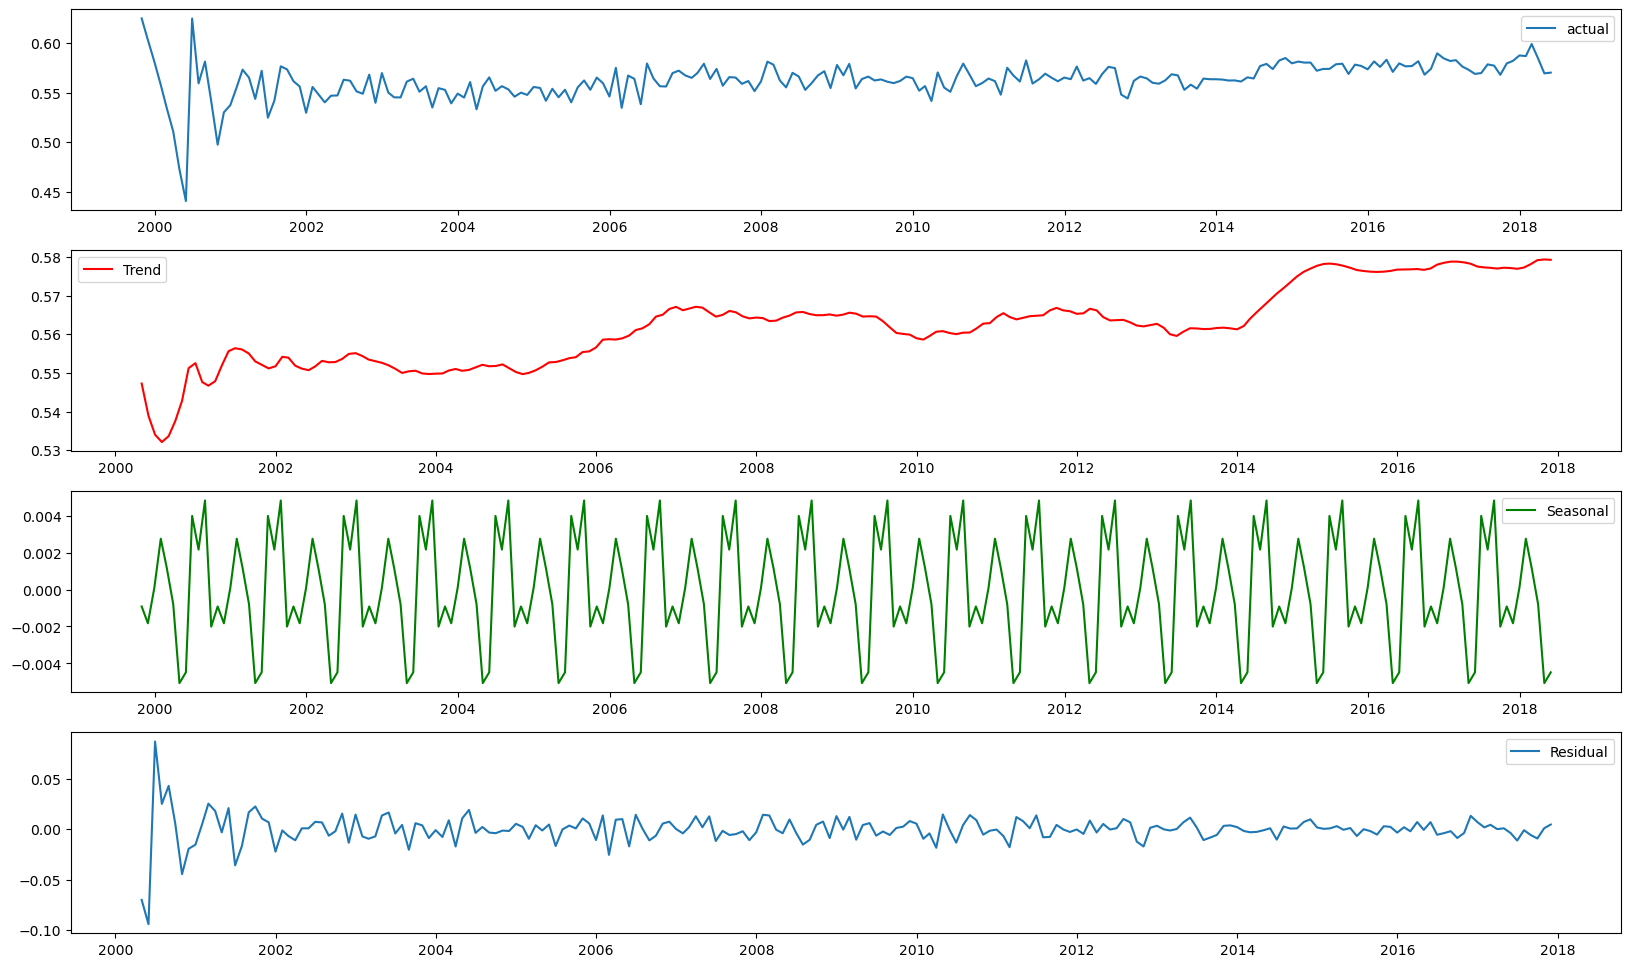

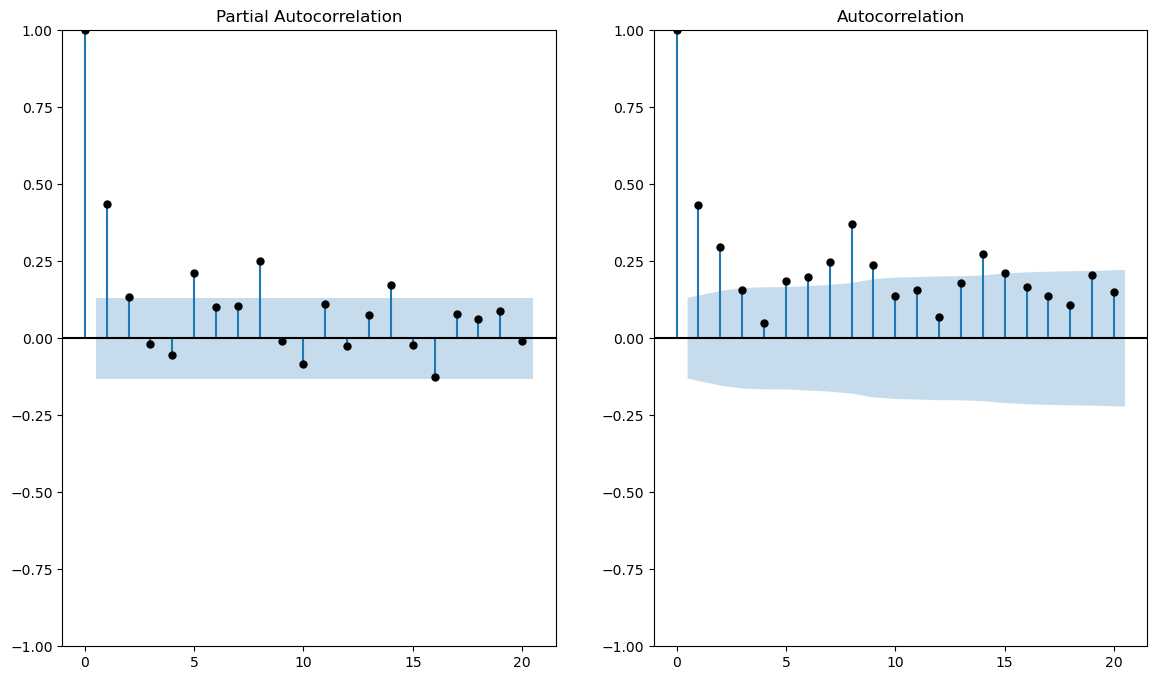

In [65]:
resample(df1,20)

In [66]:
bestvalue(2,0,1,2,0,2)

Min RMSE at index: 7
RMSE values for the models at index:  0 0.5582333056236464
RMSE values for the models at index:  1 0.3299546525503033
RMSE values for the models at index:  2 0.15595913697002833
RMSE values for the models at index:  3 0.15579909010708118
RMSE values for the models at index:  4 0.05490579376412407
RMSE values for the models at index:  5 0.05503950214653497
RMSE values for the models at index:  6 0.05492886286108995
RMSE values for the models at index:  7 0.05486140457350282

Model(p,d,q), (P, D, Q) at indexs:
0 ((0, 0, 0), (0, 0, 0))
1 ((0, 0, 0), (0, 0, 1))
2 ((0, 0, 0), (1, 0, 0))
3 ((0, 0, 0), (1, 0, 1))
4 ((1, 0, 0), (0, 0, 0))
5 ((1, 0, 0), (0, 0, 1))
6 ((1, 0, 0), (1, 0, 0))
7 ((1, 0, 0), (1, 0, 1))


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fail to reject H0. Hence the selected model is good model
RMSE value for the model: 0.00018204397957304391


-----------------------------------------Model Summary:---------------------------------------------



C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                       
 Dep. Variable:                             compound   No. Observations:                  156
 Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 414.797
 Date:                              Tue, 18 Apr 2023   AIC                           -817.594
 Time:                                      15:09:46   BIC                           -799.295
 Sample:                                  10-31-1999   HQIC                          -810.162
                                        - 09-30-2012                                         
 Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             0.1232      0.001    1

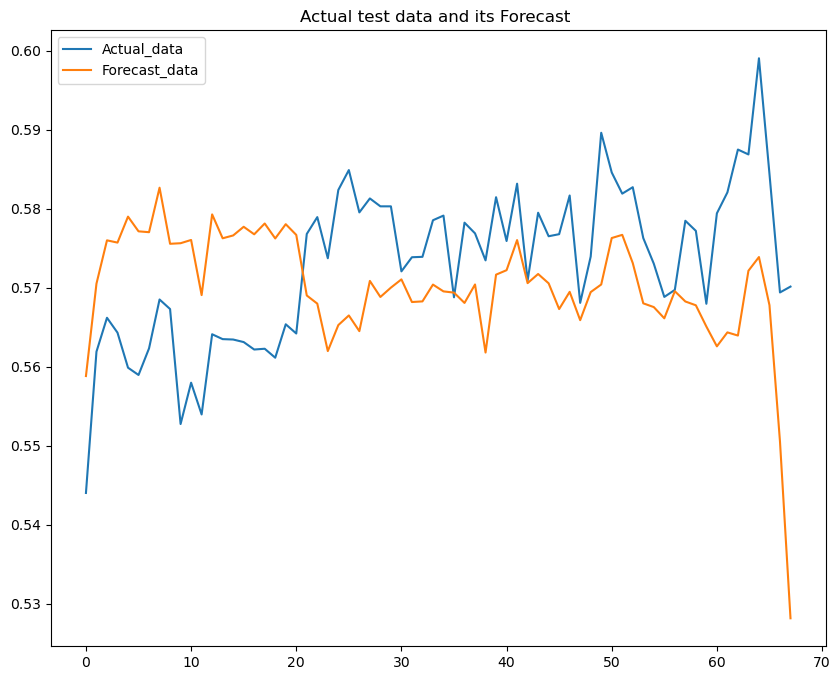

In [67]:
sarimax1(1,0,0,1,0,1,12)

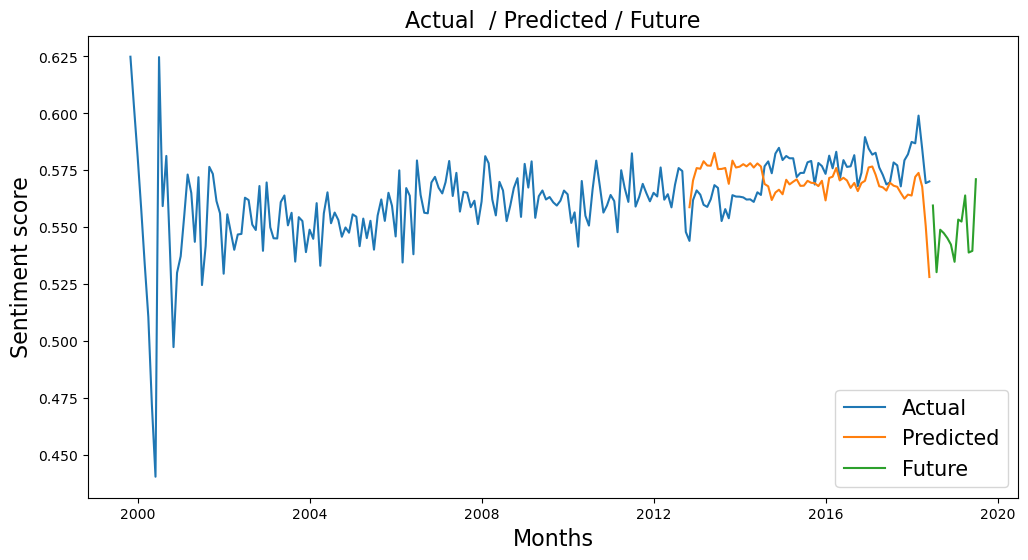

In [68]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:81])
#Plot actual,predicted forecast and future forecast data
Futureplot(47)

# ---------------------------------------Negative Sentiment----------------------------------------

Pvalue for data 0.0
Data is stationary. Proceed to model building

70% train data=151,30% test data=66
70% train data=151,30% test data=66


(             overall          rank  Number_of_Words_in_review  compound
 reviewTime                                                             
 2000-05-31  5.000000  1.028501e+06                 118.000000 -0.102700
 2000-06-30  5.000000  4.030570e+05                 184.000000 -0.557400
 2000-07-31  4.500000  1.129122e+06                  59.000000 -0.289700
 2000-08-31  4.250000  1.773796e+06                 121.000000 -0.379725
 2000-09-30  1.666667  2.454949e+06                 130.000000 -0.422500
 ...              ...           ...                        ...       ...
 2018-01-31  2.390728  1.610046e+05                  53.576159 -0.385994
 2018-02-28  2.041667  3.807789e+05                  45.430556 -0.385922
 2018-03-31  2.058824  1.202082e+05                  48.794118 -0.361432
 2018-04-30  2.070423  2.795124e+05                  47.183099 -0.387645
 2018-05-31  1.833333  3.446987e+05                  28.166667 -0.288333
 
 [217 rows x 4 columns],
 reviewTime
 2000-05-31 

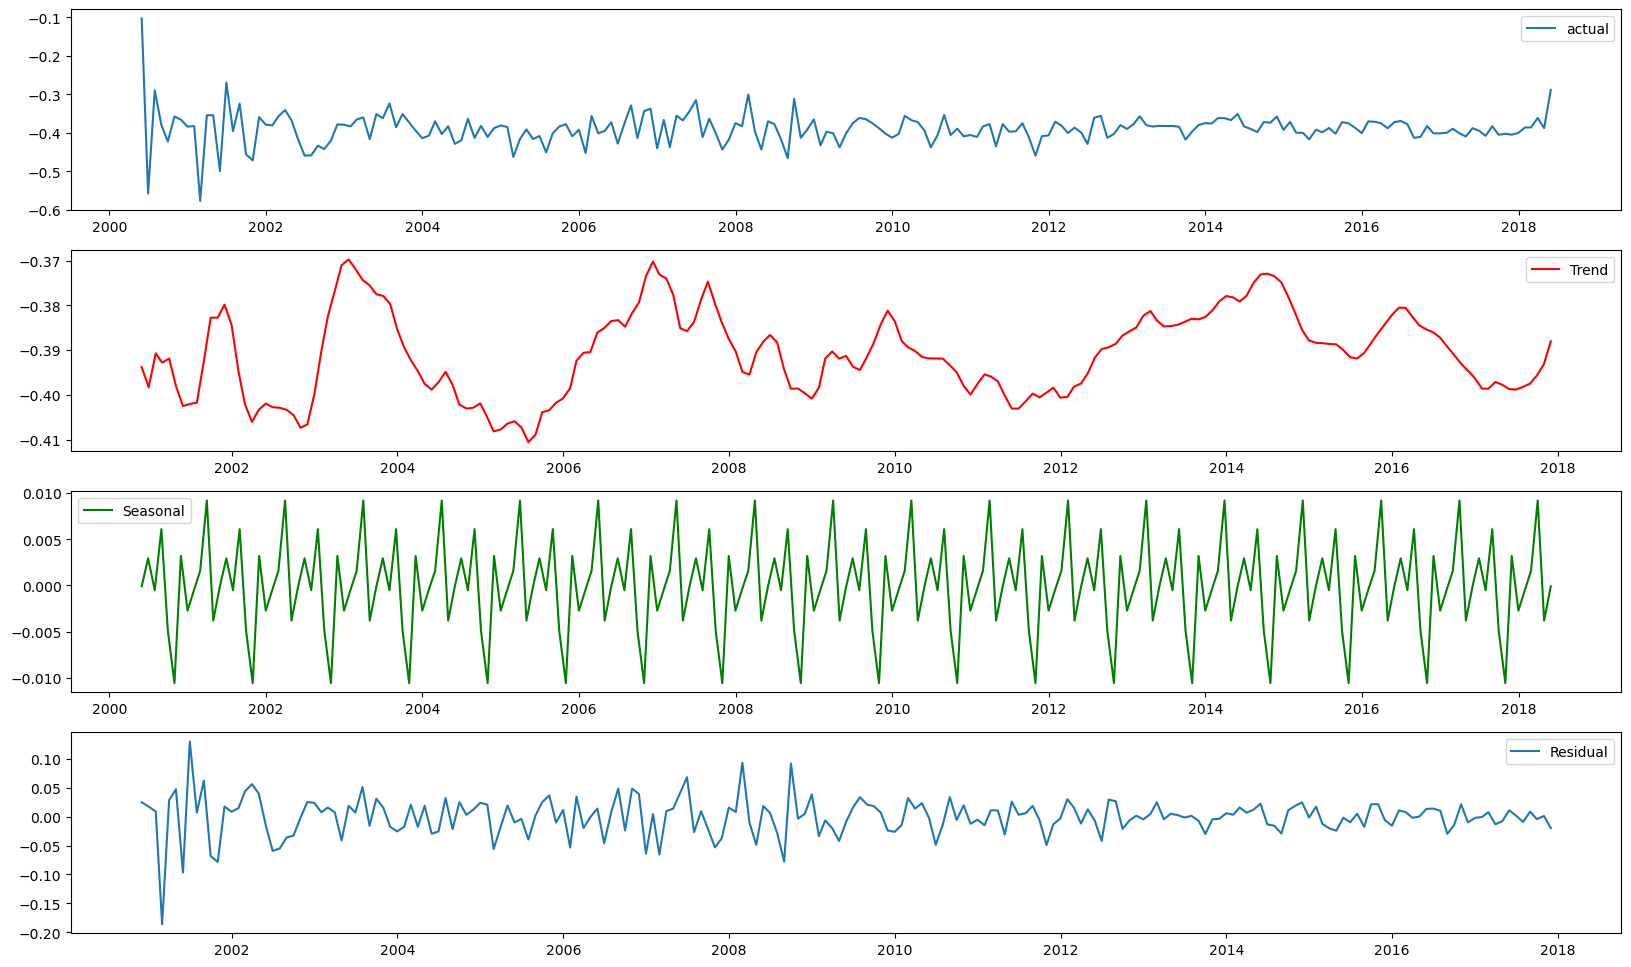

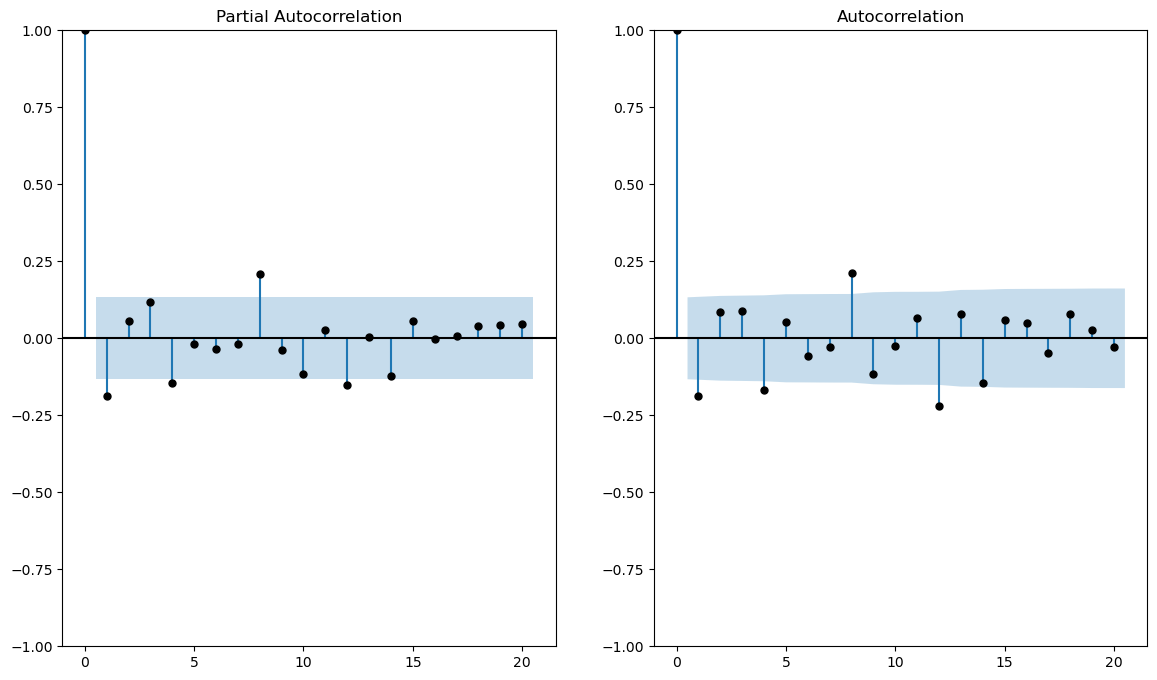

In [69]:
resample(df2,20)

In [70]:
bestvalue(3,0,1,2,0,2)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Min RMSE at index: 9
RMSE values for the models at index:  0 0.39410297382799925
RMSE values for the models at index:  1 0.2476059364433242
RMSE values for the models at index:  2 0.129781194728946
RMSE values for the models at index:  3 0.12580942190659036
RMSE values for the models at index:  4 0.07090283787622789
RMSE values for the models at index:  5 0.06964749651885983
RMSE values for the models at index:  6 0.0703107734236008
RMSE values for the models at index:  7 0.07053439964562411
RMSE values for the models at index:  8 0.06258064434677361
RMSE values for the models at index:  9 0.06132894979494641
RMSE values for the models at index:  10 0.061397452174864385
RMSE values for the models at index:  11 0.06175936094338293

Model(p,d,q), (P, D, Q) at indexs:
0 ((0, 0, 0), (0, 0, 0))
1 ((0, 0, 0), (0, 0, 1))
2 ((0, 0, 0), (1, 0, 0))
3 ((0, 0, 0), (1, 0, 1))
4 ((1, 0, 0), (0, 0, 0))
5 ((1, 0, 0), (0, 0, 1))
6 ((1, 0, 0), (1, 0, 0))
7 ((1, 0, 0), (1, 0, 1))
8 ((2, 0, 0), (0, 0, 0))

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Reject H0. Bad Model
RMSE value for the model: 0.0037912871792725902


-----------------------------------------Model Summary:---------------------------------------------



C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                       
 Dep. Variable:                             compound   No. Observations:                  151
 Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 137.117
 Date:                              Tue, 18 Apr 2023   AIC                           -260.234
 Time:                                      15:09:58   BIC                           -239.113
 Sample:                                  05-31-2000   HQIC                          -251.654
                                        - 11-30-2012                                         
 Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1            -0.1358      0.007    -

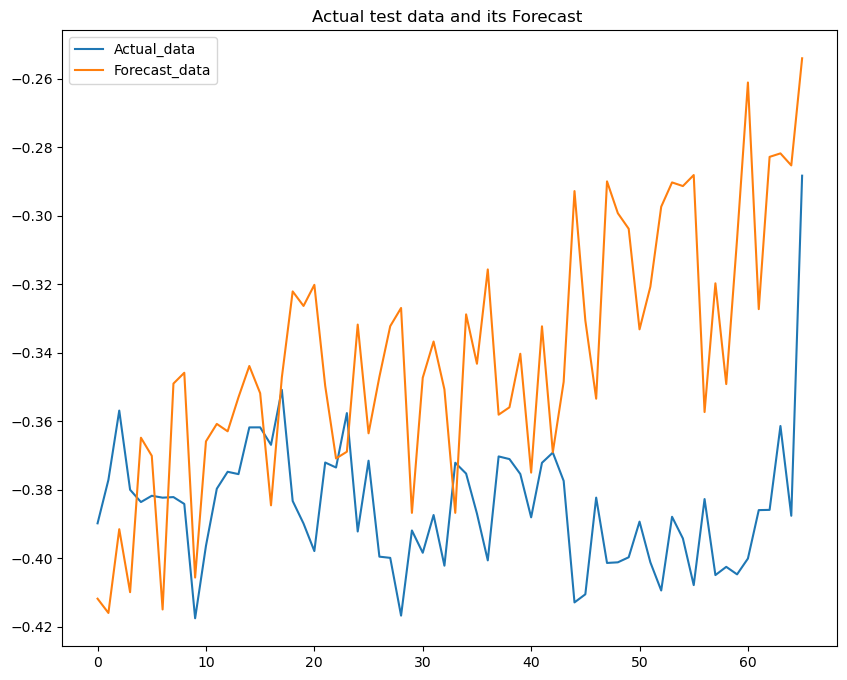

In [71]:
sarimax1(2,0,0,1,0,1,12)

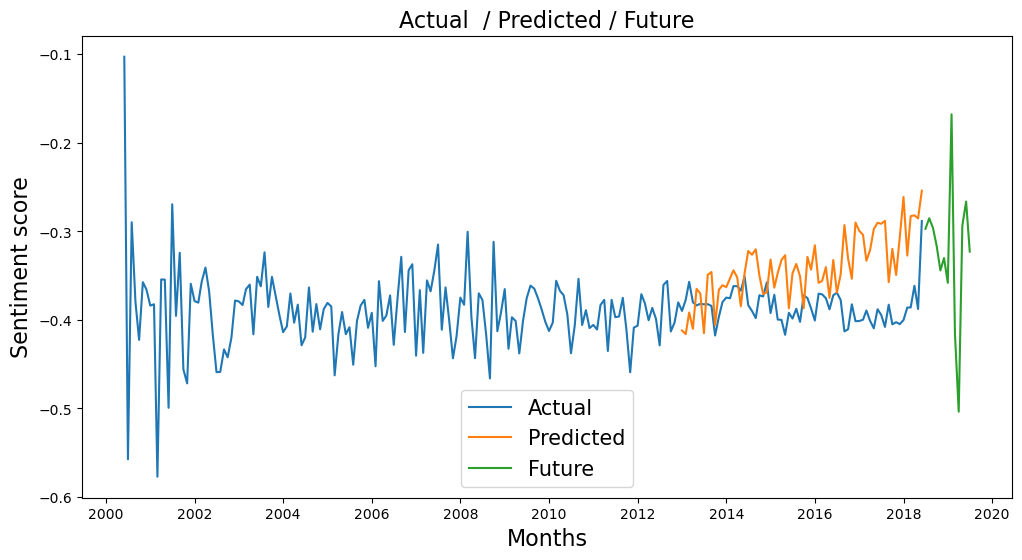

In [72]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:79])


#Plot actual,predicted forecast and future forecast data
Futureplot(47)

# ----------------------------------------Neutral Sentiment-----------------------------------------

Pvalue for data 1.3827819703472726e-22
Data is stationary. Proceed to model building

70% train data=155,30% test data=67
70% train data=155,30% test data=67


(             overall          rank  Number_of_Words_in_review  compound
 reviewTime                                                             
 1999-12-31  5.000000  1.187618e+06                 342.500000  0.000000
 2000-01-31  5.000000  1.108060e+06                 207.250000  0.000000
 2000-02-29  5.000000  1.028501e+06                  72.000000  0.000000
 2000-03-31  4.666667  1.108910e+06                  90.000000  0.000000
 2000-04-30  4.333333  1.189319e+06                 108.000000  0.000000
 ...              ...           ...                        ...       ...
 2018-01-31  4.305895  8.167074e+04                  19.878754  0.000049
 2018-02-28  4.332180  1.198265e+05                  18.081315  0.000045
 2018-03-31  4.251953  1.103462e+05                  17.216797  0.000000
 2018-04-30  3.973333  2.102250e+05                  17.400000  0.000134
 2018-05-31  3.511628  2.071436e+05                  18.232558  0.000000
 
 [222 rows x 4 columns],
 reviewTime
 1999-12-31 

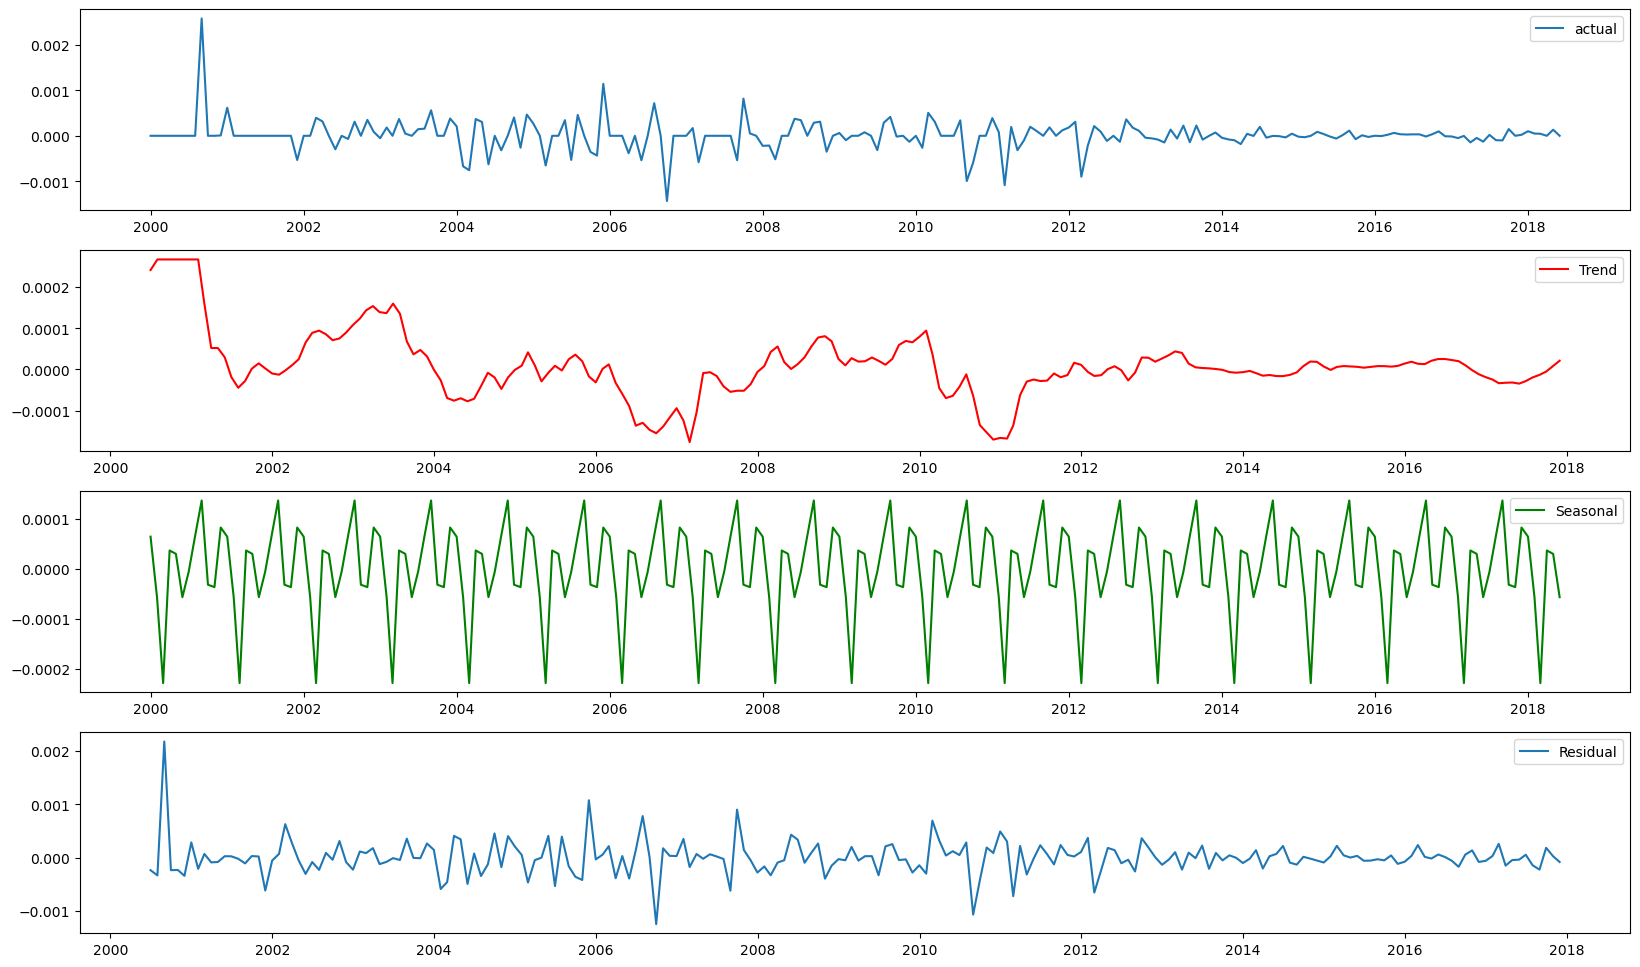

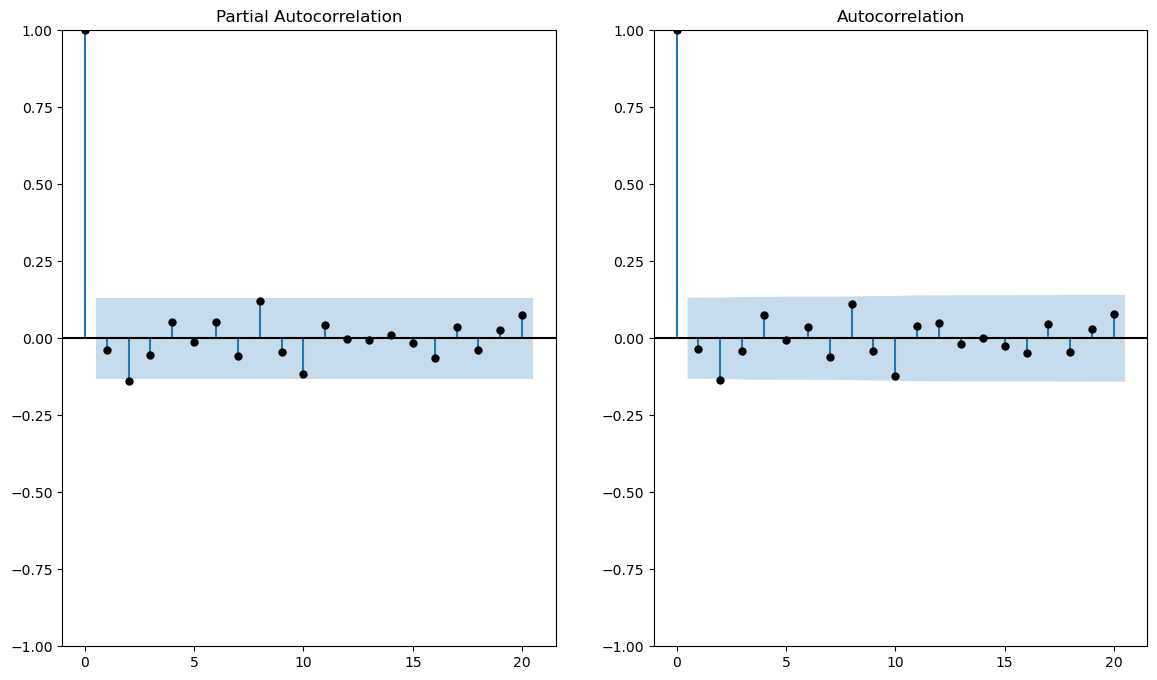

In [73]:
resample(df3,20)

In [74]:
bestvalue(5,0,3,2,0,2)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

Min RMSE at index: 46
RMSE values for the models at index:  0 0.000392397507181526
RMSE values for the models at index:  1 0.0003921384363273074
RMSE values for the models at index:  2 0.0003919799573803074
RMSE values for the models at index:  3 0.0003920354401275776
RMSE values for the models at index:  4 0.00039210003646203146
RMSE values for the models at index:  5 0.0003918193682693683
RMSE values for the models at index:  6 0.0003916723082312747
RMSE values for the models at index:  7 0.0003917167629712118
RMSE values for the models at index:  8 0.0003884048455371368
RMSE values for the models at index:  9 0.0003887905867489503
RMSE values for the models at index:  10 0.00038826974886280635
RMSE values for the models at index:  11 0.000388706852945151
RMSE values for the models at index:  12 0.000392187087224929
RMSE values for the models at index:  13 0.0003919051259001775
RMSE values for the models at index:  14 0.00039175894070756065
RMSE values for the models at index:  15 0.

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fail to reject H0. Hence the selected model is good model
RMSE value for the model: 7.124438151682214e-09


-----------------------------------------Model Summary:---------------------------------------------



(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                            compound   No. Observations:                  155
 Model:             SARIMAX(4, 0, 2)x(1, 0, [], 12)   Log Likelihood                 996.356
 Date:                             Tue, 18 Apr 2023   AIC                          -1972.712
 Time:                                     15:10:24   BIC                          -1942.277
 Sample:                                 12-31-1999   HQIC                         -1960.350
                                       - 10-31-2012                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1         -3.919e-06   1.69e-05     -0.232  

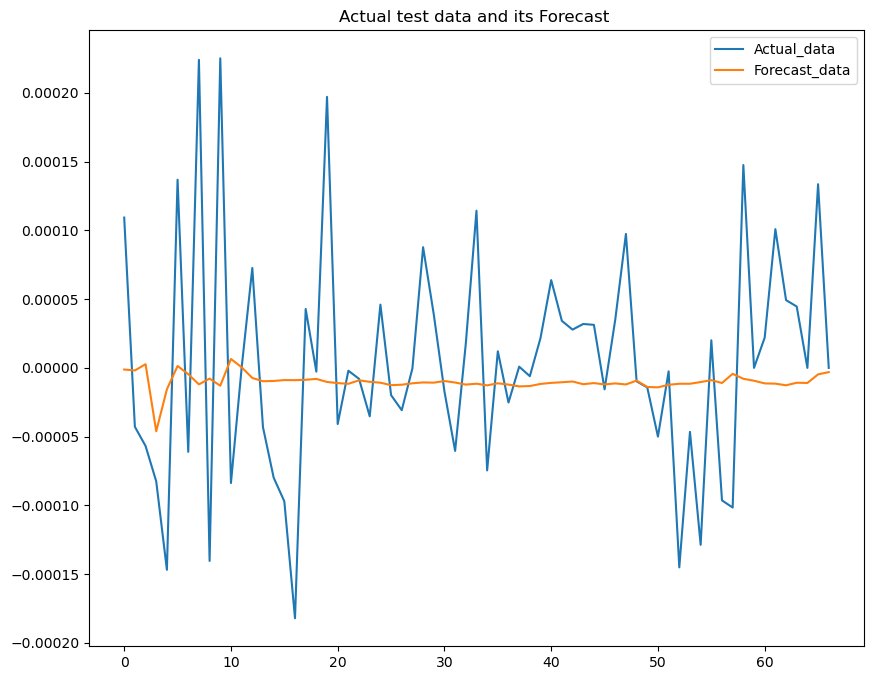

In [75]:
sarimax1(4,0,2,1,0,0,12)

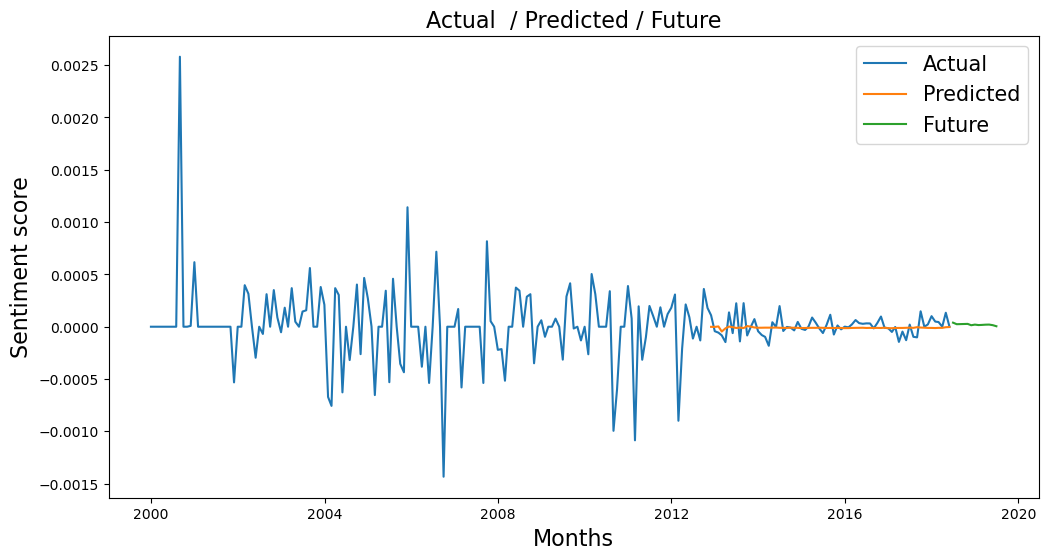

In [76]:
#Done future forecast of data we had given for resample
fcast = m1.predict(len(data_w),len(data_w)+12,exog=exog_train[:80])


#Plot actual,predicted forecast and future forecast data
Futureplot(47) 